In [9]:
import pandas as pd

# 1) Pull daily Nikkei‐225 from Stooq (2010–2024)
url = "https://stooq.com/q/d/l/?s=^nkx&d1=20100101&d2=20241231&i=d"
nikkei = pd.read_csv(url)

# 2) Clean and re‐index
nikkei.columns = ["date", "open", "high", "low", "close", "volume"]
nikkei["date"] = pd.to_datetime(nikkei["date"])
nikkei = nikkei.sort_values("date").reset_index(drop=True)

# 3) Keep only date + close price, add time_idx
nikkei = nikkei[["date", "close"]].rename(columns={"close": "price"})
nikkei["time_idx"] = range(len(nikkei))

# Now ‘nikkei’ has:
#   date      (datetime)
#   price     (float)
#   time_idx  (0, 1, 2, …)
# which is exactly what TFT needs next.


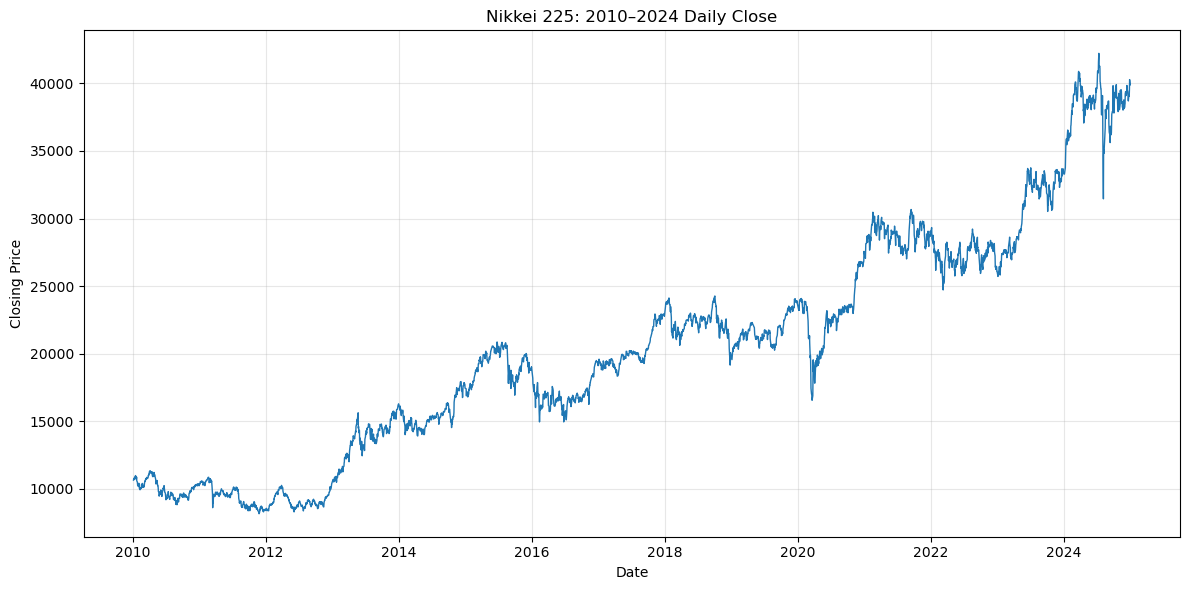

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(nikkei["date"], nikkei["price"], color="tab:blue", linewidth=1)
plt.title("Nikkei 225: 2010–2024 Daily Close")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# 1) Add a constant group ID for the single time series
nikkei["group"] = "Nikkei"  

# 2) Define cutoff indices
max_time_idx = nikkei["time_idx"].max()
train_cutoff = int(0.8 * max_time_idx)  # first 80% of dates for training
val_cutoff   = int(0.9 * max_time_idx)  # next 10% for validation, last 10% for test

# 3) Split DataFrames (we’ll later specify test via predict_dataset)
train_df = nikkei[nikkei["time_idx"] <= train_cutoff].copy()
val_df   = nikkei[(nikkei["time_idx"] > train_cutoff) & (nikkei["time_idx"] <= val_cutoff)].copy()
test_df  = nikkei[nikkei["time_idx"] > val_cutoff].copy()

print(f"Train points: {len(train_df)}, Val points: {len(val_df)}, Test points: {len(test_df)}")


Train points: 2937, Val points: 367, Test points: 368


In [12]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

# set lookback and forecast lengths
max_encoder_length = 60    # how many past days the model sees
max_prediction_length = 20 # how many days ahead it predicts

training_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="price",
    group_ids=["group"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["price"],
    target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

# for validation, tell TFT to only create windows for prediction
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    val_df,
    predict=True,
    stop_randomization=True
)


In [13]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(
    training_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
val_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)


In [14]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# Hyperparameters you can tune
hidden_size = 16  # number of units in LSTM layers
lstm_layers = 1   # how many LSTM layers
dropout = 0.1     # dropout rate
learning_rate = 3e-3

tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=4,
    dropout=dropout,
    hidden_continuous_size=hidden_size,
    output_size=7,  # 7 quantiles: [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]
    loss=QuantileLoss(),
    log_interval=10,  # print loss every 10 batches
    reduce_on_plateau_patience=4
)


c:\Users\felip\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\felip\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
